# Actividad 1: Deep Vision



En esta actividad, el alumno debe evaluar y comparar dos estrategias para la clasificación de imágenes en el dataset Caltech 101. El dataset ha sido preprocesado y guardado utilizando pickle.

### Estrategia 1: Red pre-entrenada

La primera estrategia a comparar debe incluir la utilización de una red preentrenada con el dataset ImageNet, llevando a cabo tareas de *transfer learning* y *fine-tuning* para clasificar los objetos de Caltech 101. Deben compararse al menos dos tipos de arquitecturas (VGGs, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, ResNet) y se debe seleccionar la que mayor precisión nos dé (información sobre las arquitecturas disponibles en https://keras.io/applications/). Se espera que el alumno utilice todas las técnicas de optimización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (weight regularization, dropout, batch normalization, data augmentation, etc.).

### Estrategia 2: Entrenar desde cero o *from scratch*

La segunda estrategia a comparar será una red neuronal profunda que el alumno debe diseñar, entrenar y optimizar. Se debe justificar empíricamente las decisiones que llevaron a la selección de atributos, capas e hiperparámetros a los que se ha llegado. Se espera que el alumno utilice todas las técnicas de optimización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (weight regularization, dropout, batch normalization, data augmentation, etc.).

-----------------------------------------------------

# Dataset preprocesado Caltech 101

A partir de Caltech 101 dataset 
- Original en http://www.vision.caltech.edu/Image_Datasets/Caltech101/#Download
- Preprocesado subido al gdrive https://drive.google.com/open?id=1ziDd-Au-Fn8XneBeDQya9MjPBoTpDqqK

### Directorio base.

In [1]:
###################################################################################################
# La utilizacion de un directorio base es obligatoria
# Todas las referencias al disco duro (guardar o cargar) deberan tener esta variable como base
###################################################################################################
BASE_FOLDER = "/content/drive/My Drive/2. Estudios/master artificial intelligence/viu-fundamentos_redes_neuronales/tasks/act_1-Alberto_Vargas/"
###################################################################################################

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Libraries.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras import Model

# optimization
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.regularizers import l1_l2, l2

# pre-trained models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50

### Functions.

In [72]:
def to_numeric(y_train):
  '''Transformando las labels de texto a valores numéricos'''
  y_set = np.unique(y_train)
  mapping = { key : value for key,value in zip(y_set,range(len(y_set)))}
  y_train_num = np.array([mapping[i] for i in y_train])
  return y_set, y_train_num

def plotting_model(model, epochs):
  '''Plotting model performance'''
  plt.style.use("ggplot")
  plt.figure()
  x_axis= np.arange(1,epochs+1)
  plt.plot(x_axis, model.history["loss"], label="train_loss")
  plt.plot(x_axis, model.history["val_loss"], label="val_loss")
  plt.plot(x_axis, model.history["accuracy"], label="train_acc")
  plt.plot(x_axis, model.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()


### Cómo cargar los archivos con referencia al directorio base.
- Descargamos y descomprimimos el dataset Caltech 101.
- Cargar las ndarrays.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tarfile
import pickle
%matplotlib inline

In [6]:
with open(BASE_FOLDER+"pickle_all_images_df.pickle", "rb") as input_file:
    x_train = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train = pickle.load(input_file)

- Some preview:

In [ ]:
#print(x_train.shape)
#print(len(y_train))

In [ ]:
# # showing some stuff 
# imgplot = plt.imshow(x_train[9144])
# plt.show()

In [ ]:
# print(y_train[129])

------------------------------------

# Estrategia 1: Red pre-entrenada.

- Utilización de una red preentrenada con el dataset ImageNet
- Transfer learning y fine-tuning para clasificar los objetos de Caltech 101. 
- Comparar al menos dos tipos de arquitecturas (VGGs, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, ResNet)
- Seleccionar la que mayor precisión nos dé (información sobre las arquitecturas disponibles en https://keras.io/applications/).
- Utilizar todas las técnicas de optimización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (weight regularization, dropout, batch normalization, data augmentation, etc.).

----------------------------------------



Usaremos los modelos VGG19 y ResNet-50. Para ambos se ha implementado:
- Data augmentation (para el dataset).
- Transranfer-learning.
- Fine-tuning.

In [7]:
# Transformando las labels de texto a valores numéricos
y_set, y_train_num = to_numeric(y_train)

In [8]:
# train_test_split. Sobreescribiendo las variables ahorramos espacio.
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train_num, test_size = 0.20)
#del y_train, x_train 

#One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [9]:
# Normalizar data
x_train = x_train.astype('float')*255.0
x_test = x_test.astype('float')*255.0

x_train = imagenet_utils.preprocess_input(x_train)
x_test = imagenet_utils.preprocess_input(x_test)

print("Train: ", x_train.shape)
print("\nTest: ", x_test.shape)

Train:  (7316, 128, 128, 3)

Test:  (1829, 128, 128, 3)


- Data Augmentation. 
Hemos comprobado que con Data Augmentation mejoramos los resultados, así que los incluímos desde el principio.

In [39]:
#Contenedor DataGenerator
data_generator = ImageDataGenerator(rotation_range = 15,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    validation_split = 0.2)


### Modelo 1: VGG19.

In [40]:
base_model_vgg = VGG19(weights = 'imagenet', include_top = False, input_shape = (128,128,3))
base_model_vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

- Transfer-learning.

In [41]:
base_model_vgg.trainable = False  

pre_trained_model_vgg = Sequential()
pre_trained_model_vgg.add(base_model_vgg)
pre_trained_model_vgg.add(layers.Flatten())
pre_trained_model_vgg.add(layers.Dense(512, activation = 'relu'))
pre_trained_model_vgg.add(layers.Dropout(0.5))
pre_trained_model_vgg.add(layers.Dense(512, activation = 'relu'))
pre_trained_model_vgg.add(layers.Dropout(0.2))
pre_trained_model_vgg.add(layers.Dense(102, activation = 'softmax'))

pre_trained_model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 102)              

- Training.

In [42]:
# Compiling
pre_trained_model_vgg.compile(loss = "categorical_crossentropy", 
                              optimizer = Adam(learning_rate= 0.001, decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
                              metrics = ["accuracy"])

In [43]:
# Data Augmentation
epochs= 15
vgg_aug = pre_trained_model_vgg.fit(data_generator.flow(x_train, y_train, batch_size = 128, subset = 'training'), 
                                    steps_per_epoch = len(x_train)*4/128, epochs = epochs, workers = 2,
                                    validation_data = data_generator.flow(x_train, y_train, batch_size = 128, subset = 'validation'))

Epoch 1/15
228/228 [==============================] - 72s 309ms/step - loss: 3.3020 - accuracy: 0.4417 - val_loss: 1.6987 - val_accuracy: 0.6494
Epoch 2/15
228/228 [==============================] - 74s 321ms/step - loss: 2.1361 - accuracy: 0.5803 - val_loss: 1.5124 - val_accuracy: 0.6945
Epoch 3/15
228/228 [==============================] - 65s 283ms/step - loss: 1.9313 - accuracy: 0.6216 - val_loss: 1.5048 - val_accuracy: 0.6951
Epoch 4/15
228/228 [==============================] - 64s 276ms/step - loss: 1.7213 - accuracy: 0.6560 - val_loss: 1.3614 - val_accuracy: 0.7293
Epoch 5/15
228/228 [==============================] - 65s 284ms/step - loss: 1.5850 - accuracy: 0.6782 - val_loss: 1.3062 - val_accuracy: 0.7348
Epoch 6/15
228/228 [==============================] - 67s 290ms/step - loss: 1.4435 - accuracy: 0.7010 - val_loss: 1.2096 - val_accuracy: 0.7478
Epoch 7/15
228/228 [==============================] - 65s 281ms/step - loss: 1.3617 - accuracy: 0.7127 - val_loss: 1.1788 - val_ac

In [44]:
# Saving model (por si me crashea colab)
pre_trained_model_vgg.save(BASE_FOLDER+"strategy_1_model_vgg_augmented.h5")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation:  
                    precision    recall  f1-score   support

BACKGROUND_Google       0.47      0.67      0.56        83
            Faces       0.97      1.00      0.98        88
       Faces_easy       1.00      0.98      0.99        86
         Leopards       0.93      1.00      0.96        40
       Motorbikes       0.99      1.00      0.99       144
        accordion       0.75      1.00      0.86         9
        airplanes       0.95      0.98      0.97       173
           anchor       1.00      0.09      0.17        11
              ant       0.82      0.75      0.78        12
           barrel       1.00      0.62      0.77         8
             bass       0.71      0.38      0.50        13
           beaver       1.00      0.22      0.36         9
        binocular       1.00      0.71      0.83         7
           bonsai       0.93      0.86      0.89        29
            brain       0.89      1.00      0.94        25
     brontosaurus       0.00      0.00  

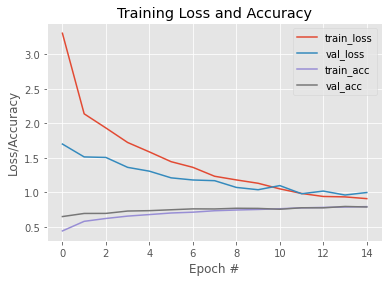

In [45]:
# Evaluation
predictions = pre_trained_model_vgg.predict(x_test, batch_size=128)
print("Evaluation: ",
      "\n",
      classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names = y_set)
      )

# # graphs
# epochs is externally defined above in order to be implemented here
plotting_model(vgg_aug, epochs)

- Hubiera sido buena idea definir más epochs para ver cómo se estabilizan el *train* y *val loss*. Seguramente se estabilizaría dando resultados óptimos (pero hay que encontrar un compromiso entre tiempo de cómputo y fechas límite).

- De la misma manera, *train* y *val accuracy* siguen una trayectoria ascendente y con más epochs conseguiríamos una mayor performance, parece que sin signos notables de overfitting.

Tenemos un accuracy mayor al 80% y lo damos por válido de momento.

- Fine-tuning.

Vamos a reciclar todos los parámetros anteriormente usados. Volviendo a partir de nuestro *base_model*, congelamos todas las capas menos la última convolucional.

In [50]:
base_model_vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [51]:
# just playing with the last layer
for layer in base_model_vgg.layers:
  if layer.name == 'block5_conv1':
    break

  layer.trainable = False
  print("=> {} frozen".format(layer.name))

=> input_2 frozen
=> block1_conv1 frozen
=> block1_conv2 frozen
=> block1_pool frozen
=> block2_conv1 frozen
=> block2_conv2 frozen
=> block2_pool frozen
=> block3_conv1 frozen
=> block3_conv2 frozen
=> block3_conv3 frozen
=> block3_conv4 frozen
=> block3_pool frozen
=> block4_conv1 frozen
=> block4_conv2 frozen
=> block4_conv3 frozen
=> block4_conv4 frozen
=> block4_pool frozen


In [52]:
# modifying last layer
last = base_model_vgg.layers[-1].output

x = Flatten()(last)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(102, activation = 'softmax')(x)

pre_trained_model_vgg_fine = Model(base_model_vgg.input, x)

In [53]:
# Compiling
pre_trained_model_vgg_fine.compile(loss = "categorical_crossentropy", 
                              optimizer = Adam(learning_rate= 0.001, decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
                              metrics = ["accuracy"])

In [54]:
# Data Augmentation
epochs= 15
vgg_aug_fine = pre_trained_model_vgg_fine.fit(data_generator.flow(x_train, y_train, batch_size = 128, subset = 'training'), 
                                    steps_per_epoch = len(x_train)*4/128, epochs = epochs, workers = 2,
                                    validation_data = data_generator.flow(x_train, y_train, batch_size = 128, subset = 'validation'))

Epoch 1/15
228/228 [==============================] - 65s 281ms/step - loss: 3.9812 - accuracy: 0.3581 - val_loss: 2.3191 - val_accuracy: 0.5605
Epoch 2/15
228/228 [==============================] - 70s 305ms/step - loss: 2.5840 - accuracy: 0.4928 - val_loss: 2.0132 - val_accuracy: 0.5974
Epoch 3/15
228/228 [==============================] - 63s 275ms/step - loss: 2.3900 - accuracy: 0.5267 - val_loss: 1.9899 - val_accuracy: 0.6200
Epoch 4/15
228/228 [==============================] - 73s 319ms/step - loss: 2.2427 - accuracy: 0.5554 - val_loss: 1.9287 - val_accuracy: 0.6220
Epoch 5/15
228/228 [==============================] - 67s 291ms/step - loss: 2.1536 - accuracy: 0.5668 - val_loss: 1.8889 - val_accuracy: 0.6336
Epoch 6/15
228/228 [==============================] - 64s 278ms/step - loss: 2.0421 - accuracy: 0.5831 - val_loss: 1.7543 - val_accuracy: 0.6576
Epoch 7/15
228/228 [==============================] - 63s 277ms/step - loss: 2.0090 - accuracy: 0.5900 - val_loss: 1.8520 - val_ac

In [55]:
# Saving model (por si me crashea colab)
pre_trained_model_vgg_fine.save(BASE_FOLDER+"strategy_1_model_vgg_augmented-fine_tuning.h5")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation:  
                    precision    recall  f1-score   support

BACKGROUND_Google       0.32      0.83      0.46        83
            Faces       0.98      1.00      0.99        88
       Faces_easy       1.00      0.97      0.98        86
         Leopards       0.87      1.00      0.93        40
       Motorbikes       0.97      1.00      0.99       144
        accordion       0.88      0.78      0.82         9
        airplanes       0.96      0.97      0.97       173
           anchor       0.00      0.00      0.00        11
              ant       0.00      0.00      0.00        12
           barrel       1.00      0.75      0.86         8
             bass       0.00      0.00      0.00        13
           beaver       0.00      0.00      0.00         9
        binocular       0.00      0.00      0.00         7
           bonsai       0.96      0.86      0.91        29
            brain       0.96      0.92      0.94        25
     brontosaurus       0.00      0.00  

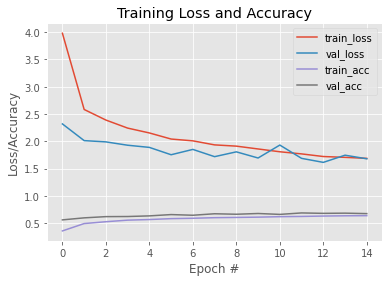

In [56]:
# Evaluation
predictions = pre_trained_model_vgg_fine.predict(x_test, batch_size=128)
print("Evaluation: ",
      "\n",
      classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names = y_set)
      )

# # graphs
# epochs is externally defined above in order to be implemented here
plotting_model(vgg_aug_fine , epochs)

- El fine tuning ejecutado no mejora los resultados obtenidos con el número de épocas con el que estamos trabajando, pero lo dejamos por aquí para dar cuenta del método utilizado. 

- Observando las trayectorias de *train/val loss* y *train/val accuracy*, merece la pena trabajar con más épocas y ver si conseguimos mejorar el resultado.

### Modelo 2: ResNet-50.

Usamos de inicio Data Augmentation.

- Data augmentation.

In [57]:
# DataGenerator
'''Generado anteriormente'''

'Generado anteriormente'

In [58]:
base_model_resnet = ResNet50(weights = 'imagenet', include_top = False, input_shape = (128,128,3))
base_model_resnet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
__________________________

- Transfer Learning.

In [59]:
base_model_resnet.trainable = False
pre_trained_model_resnet = Sequential()

pre_trained_model_resnet.add(base_model_resnet)
pre_trained_model_resnet.add(layers.Flatten())
pre_trained_model_resnet.add(layers.Dense(256, activation = 'relu'))
pre_trained_model_resnet.add(layers.BatchNormalization())
pre_trained_model_resnet.add(layers.Dropout(0.75))
pre_trained_model_resnet.add(layers.Dense(256, activation = 'relu'))
pre_trained_model_resnet.add(layers.BatchNormalization())
pre_trained_model_resnet.add(layers.Dropout(0.75)) 
pre_trained_model_resnet.add(layers.Dense(102, activation = 'softmax'))

pre_trained_model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               8388864   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)              

In [60]:
# Compiling
pre_trained_model_resnet.compile(loss = "categorical_crossentropy", 
                              optimizer = Adam(learning_rate= 0.001, decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
                              metrics = ["accuracy"])

In [61]:
# Data Augmentation
epochs= 15
resnet_aug = pre_trained_model_resnet.fit(data_generator.flow(x_train, y_train, batch_size = 128, subset = 'training'), 
                                    steps_per_epoch = len(x_train)*4/128, epochs = epochs, workers = 2,
                                    validation_data = data_generator.flow(x_train, y_train, batch_size = 128, subset = 'validation'))

Epoch 1/15
228/228 [==============================] - 66s 271ms/step - loss: 3.3920 - accuracy: 0.3229 - val_loss: 1.5369 - val_accuracy: 0.6521
Epoch 2/15
228/228 [==============================] - 61s 266ms/step - loss: 2.0450 - accuracy: 0.5131 - val_loss: 1.0109 - val_accuracy: 0.7580
Epoch 3/15
228/228 [==============================] - 61s 264ms/step - loss: 1.5655 - accuracy: 0.5978 - val_loss: 0.7602 - val_accuracy: 0.8148
Epoch 4/15
228/228 [==============================] - 64s 281ms/step - loss: 1.3181 - accuracy: 0.6521 - val_loss: 0.6974 - val_accuracy: 0.8360
Epoch 5/15
228/228 [==============================] - 68s 297ms/step - loss: 1.1549 - accuracy: 0.6857 - val_loss: 0.6474 - val_accuracy: 0.8291
Epoch 6/15
228/228 [==============================] - 64s 277ms/step - loss: 1.0552 - accuracy: 0.7095 - val_loss: 0.6034 - val_accuracy: 0.8366
Epoch 7/15
228/228 [==============================] - 66s 286ms/step - loss: 0.9687 - accuracy: 0.7303 - val_loss: 0.5793 - val_ac

In [62]:
# Saving model (por si me crashea colab)
pre_trained_model_resnet.save(BASE_FOLDER+"strategy_1_model_resnet_augmented.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Evaluation:  
                    precision    recall  f1-score   support

BACKGROUND_Google       0.68      0.73      0.71        83
            Faces       0.97      1.00      0.98        88
       Faces_easy       1.00      0.98      0.99        86
         Leopards       0.93      1.00      0.96        40
       Motorbikes       1.00      1.00      1.00       144
        accordion       0.90      1.00      0.95         9
        airplanes       0.97      0.99      0.98       173
           anchor       1.00      0.73      0.84        11
              ant       0.80      0.33      0.47        12
           barrel       1.00      0.88      0.93         8
             bass       0.67      0.62      0.64        13
           beaver       0.60      0.67      0.63         9
        binocular       1.00      0.86      0.92         7
           bonsai       0.91      1.00      0.95        29
            brain       0.83      1.00      0.91        25
     brontosaurus       0.43      0.43  

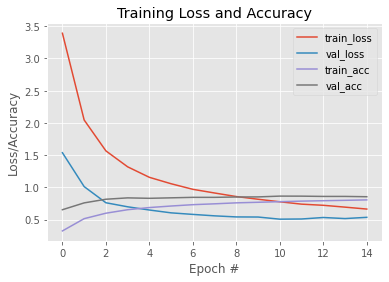

In [63]:
# Evaluation
predictions = pre_trained_model_resnet.predict(x_test, batch_size=128)
print("Evaluation: ",
      "\n",
      classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names = y_set)
      )

# # graphs
# epochs is externally defined above in order to be implemented here
plotting_model(resnet_aug, epochs)

- Con este modelo tenemos mejor accuracy y una mejor performance, atendiendo a la la gráfica. Igualmente, merecería la pena entrenarlo durante más épocas para estudiar cómo siguen convergiendo las curvas.

- Fine-tuning: 
De nuevo, para las épocas entrenadas, no he obtenido mejoras significativas. 

# Estrategia 2: From scratch.

Después de probar varias arquitecturas y configuraciones, este es mi resultado más interesante, basado en código que he visto por Medium/Github.

- Añadido data augmentation
- Añadido *l1&l2 regularization* 

Con todo esto, después de invertir bastante tiempo no he encontrado resultados realmente satisfactorios. 

In [67]:
model_scratch = Sequential()

model_scratch.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(128, 128, 3)))
model_scratch.add(Conv2D(32, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
model_scratch.add(Dropout(0.5))

model_scratch.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
model_scratch.add(BatchNormalization())
model_scratch.add(Dropout(0.5))

model_scratch.add(Flatten())

model_scratch.add(Dense(512, activation='relu', 
                kernel_regularizer = l1_l2(l1=0.01, l2=0.01),
                bias_regularizer = l2(0.01)))

model_scratch.add(Dense(512, activation='relu',
                kernel_regularizer = l1_l2(l1=0.01, l2=0.01),
                bias_regularizer = l2(0.01)))

model_scratch.add(BatchNormalization())
model_scratch.add(Dropout(0.5))
model_scratch.add(Dense(102, activation = 'softmax'))

In [68]:
# Compiling
model_scratch.compile(loss = "categorical_crossentropy", 
                              optimizer = Adam(learning_rate= 0.001, decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
                              metrics = ["accuracy"])

In [69]:
# Data Augmentation
epochs= 15
model_aug = model_scratch.fit(data_generator.flow(x_train, y_train, batch_size = 128, subset = 'training'), 
                                    steps_per_epoch = len(x_train)*4/128, epochs = epochs, workers = 2,
                                    validation_data = data_generator.flow(x_train, y_train, batch_size = 128, subset = 'validation'))

Epoch 1/15
228/228 [==============================] - 62s 260ms/step - loss: 129.5045 - accuracy: 0.2293 - val_loss: 39.0852 - val_accuracy: 0.0759
Epoch 2/15
228/228 [==============================] - 60s 262ms/step - loss: 37.0175 - accuracy: 0.2987 - val_loss: 37.3622 - val_accuracy: 0.2112
Epoch 3/15
228/228 [==============================] - 64s 278ms/step - loss: 36.8810 - accuracy: 0.3167 - val_loss: 37.0763 - val_accuracy: 0.2912
Epoch 4/15
228/228 [==============================] - 62s 270ms/step - loss: 37.0376 - accuracy: 0.3262 - val_loss: 37.2192 - val_accuracy: 0.3014
Epoch 5/15
228/228 [==============================] - 64s 278ms/step - loss: 36.9611 - accuracy: 0.3336 - val_loss: 37.0262 - val_accuracy: 0.3260
Epoch 6/15
228/228 [==============================] - 62s 270ms/step - loss: 36.9852 - accuracy: 0.3437 - val_loss: 37.4992 - val_accuracy: 0.3137
Epoch 7/15
228/228 [==============================] - 64s 277ms/step - loss: 37.0320 - accuracy: 0.3550 - val_loss: 3

In [70]:
# Saving model (por si me crashea colab)
model_scratch.save(BASE_FOLDER+"strategy_2_model_from_scratch_augmented.h5")

Evaluation:  
                    precision    recall  f1-score   support

BACKGROUND_Google       0.13      0.61      0.21        83
            Faces       0.93      1.00      0.96        88
       Faces_easy       0.93      0.95      0.94        86
         Leopards       0.36      0.93      0.51        40
       Motorbikes       0.96      0.94      0.95       144
        accordion       0.57      0.44      0.50         9
        airplanes       0.94      0.99      0.96       173
           anchor       0.00      0.00      0.00        11
              ant       0.00      0.00      0.00        12
           barrel       0.00      0.00      0.00         8
             bass       0.00      0.00      0.00        13
           beaver       0.00      0.00      0.00         9
        binocular       0.00      0.00      0.00         7
           bonsai       0.24      0.66      0.36        29
            brain       0.00      0.00      0.00        25
     brontosaurus       0.00      0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


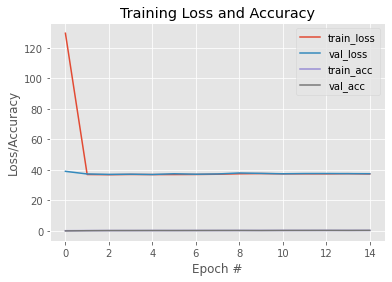

In [71]:
# Evaluation
predictions = model_scratch.predict(x_test, batch_size=128)
print("Evaluation: ",
      "\n",
      classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names = y_set)
      )

# # graphs
# epochs is externally defined above in order to be implemented here
plotting_model(model_aug, epochs)

Resultados trágicos donde los haya.

- Después de una mejora de la función de pérdida en el *training set*, *training loss* y *validation loss* realizan una mejora al final de todas las iteraciones insignificante.

- Lo mismo podemos decir de *accuracy* en el *training* y *validation set*.
Podemos decir que el modelo no aprende, y su accuracy no es satisfactorio.

- Quizás atacar un problema multiclase con muchas clases, usando una red *from scratch* no sea la forma óptima de proceder.

# Conclusiones.

Si no estamos trabajando en un problema muy sencillo, quizás la mejor forma de empezar a atacarlo es usar un modelo ya entrenado para ese propósito, y terminar de perfilarlo para nuestro caso particular (con *fine-tuning*, etc).

Me hubiera gustado usar más iteraciones a la hora de entrenar los modelos. Sin duda tendría mejores métricas, pero se me dispara el tiempo de computación.

Es necesario un preprocesamiento exhaustivo del dataset para intentar balancear todas las clases involucradas, evitando que no se pierdan las clases minoritarias y se sobre-aprendan las más pobladas.